## Escenario A: Modelo con aristas hasChemical y features de químicos

In [ ]:
# --- Cargar data ---
import numpy as np
import torch
from torch_geometric.data import HeteroData

data = torch.load("hetero_data.pt", weights_only=False)
print(data)
print("Node types:", data.node_types)
print("Edge types:", data.edge_types)
print("Product x shape:", data['Product'].x.shape)

# --- Normaliza features de todos los nodos (excepto etiquetas) ---
from sklearn.preprocessing import StandardScaler

for ntype in data.node_types:
    if hasattr(data[ntype], "x") and data[ntype].x is not None and data[ntype].x.shape[0] > 1:
        scaler = StandardScaler()
        x_np = data[ntype].x.cpu().numpy()
        data[ntype].x = torch.tensor(scaler.fit_transform(x_np), dtype=torch.float, device=data[ntype].x.device)
        print(f"Normalizados features de '{ntype}' con shape={data[ntype].x.shape}")

# --- Máscaras de train/test estratificadas ---
from sklearn.model_selection import train_test_split

labels = data["Product"].y.cpu().numpy()
indices = np.arange(len(labels))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

train_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data["Product"].train_mask = train_mask
data["Product"].test_mask = test_mask

print("Proporción en train:", np.bincount(labels[train_mask.cpu().numpy()]))
print("Proporción en test:", np.bincount(labels[test_mask.cpu().numpy()]))

# --- Recalcula valid_edge_types ---
valid_edge_types = []
for (src, rel, dst), edge_index in data.edge_index_dict.items():
    if (
        edge_index is not None
        and getattr(data[src], "x", None) is not None
        and getattr(data[dst], "x", None) is not None
        and edge_index.shape[1] > 0
    ):
        valid_edge_types.append((src, rel, dst))
print("valid_edge_types:", valid_edge_types)

# --- Agrega relaciones inversas ---
for (src, rel, dst) in valid_edge_types:
    if dst == "Product":
        continue
    edge_index = data[(src, rel, dst)].edge_index
    inv_rel = rel + "_rev"
    data[(dst, inv_rel, src)].edge_index = edge_index.flip(0)
    print(f"Agregada relación inversa: ({dst}, {inv_rel}, {src})")

# Vuelve a recalcular valid_edge_types con las nuevas relaciones
valid_edge_types = []
for (src, rel, dst), edge_index in data.edge_index_dict.items():
    if (
        edge_index is not None
        and getattr(data[src], "x", None) is not None
        and getattr(data[dst], "x", None) is not None
        and edge_index.shape[1] > 0
    ):
        valid_edge_types.append((src, rel, dst))
print("valid_edge_types (con inversas):", valid_edge_types)

# --- Calcula in_channels automáticamente ---
in_channels = {
    ntype: data[ntype].x.shape[1]
    for ntype in data.node_types
    if getattr(data[ntype], "x", None) is not None
}
print("in_channels:", in_channels)

# --- modelo ---
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GraphConv, Linear

num_classes = int(data["Product"].y.max().item() + 1)

class ProductGNN(torch.nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        conv1_dict = {}
        for (src, rel, dst) in valid_edge_types:
            conv1_dict[(src, rel, dst)] = GraphConv(
                (in_channels[src], in_channels[dst]), hidden
            )
        self.conv1 = HeteroConv(conv1_dict, aggr='sum')

        conv2_dict = {
            edge_type: GraphConv((hidden, hidden), hidden)
            for edge_type in conv1_dict
        }
        self.conv2 = HeteroConv(conv2_dict, aggr='sum')
        self.lin = Linear(hidden, num_classes)

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        out_dict = x.copy()
        out_dict["Product"] = self.lin(x["Product"])
        return out_dict

# --- Pesos de clase para CrossEntropyLoss ---
class_sample_count = np.bincount(labels)
weight = 1. / class_sample_count
weights = torch.tensor(weight, dtype=torch.float, device=data["Product"].y.device)
print("Pesos de clase:", weights)

# --- Instancia y entrena el modelo ---
model = ProductGNN(hidden=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

# --- Embeddings pre-entrenamiento ---
model.eval()
with torch.no_grad():
    x = model.conv1(data.x_dict, data.edge_index_dict)
    x = {k: F.relu(v) for k, v in x.items()}
    x = model.conv2(x, data.edge_index_dict)
    prod_emb_pre = x["Product"].cpu().numpy()


HeteroData(
  Product={
    x=[36972, 5],
    y=[36972],
  },
  Chemical={ x=[86, 5] },
  Brand={ x=[2714, 3] },
  Company={ x=[635, 3] },
  Category={ x=[13, 3] },
  SubCategory={ x=[92, 3] },
  (Product, hasBrand, Brand)={ edge_index=[2, 36972] },
  (Product, hasCategory, Category)={ edge_index=[2, 38188] },
  (Product, hasSubCategory, SubCategory)={ edge_index=[2, 40096] },
  (Product, madeBy, Company)={ edge_index=[2, 36972] },
  (Product, hasChemical, Chemical)={ edge_index=[2, 38554] }
)
Node types: ['Product', 'Chemical', 'Brand', 'Company', 'Category', 'SubCategory']
Edge types: [('Product', 'hasBrand', 'Brand'), ('Product', 'hasCategory', 'Category'), ('Product', 'hasSubCategory', 'SubCategory'), ('Product', 'madeBy', 'Company'), ('Product', 'hasChemical', 'Chemical')]
Product x shape: torch.Size([36972, 5])
Normalizados features de 'Product' con shape=torch.Size([36972, 5])
Normalizados features de 'Chemical' con shape=torch.Size([86, 5])
Normalizados features de 'Brand' con 

Epoch 01 | Loss: 1.0135 | Test Acc: 0.4688 | F1: 0.3752
Epoch 02 | Loss: 0.9391 | Test Acc: 0.2887 | F1: 0.2834
Epoch 03 | Loss: 0.8310 | Test Acc: 0.3530 | F1: 0.3337
Epoch 04 | Loss: 0.7469 | Test Acc: 0.4965 | F1: 0.4151
Epoch 05 | Loss: 0.7041 | Test Acc: 0.6292 | F1: 0.4858
Epoch 06 | Loss: 0.6530 | Test Acc: 0.6747 | F1: 0.5255
Epoch 07 | Loss: 0.6069 | Test Acc: 0.6510 | F1: 0.5437
Epoch 08 | Loss: 0.5876 | Test Acc: 0.5802 | F1: 0.5090
Epoch 09 | Loss: 0.5781 | Test Acc: 0.5737 | F1: 0.5106
Epoch 10 | Loss: 0.5617 | Test Acc: 0.6142 | F1: 0.5395
Epoch 11 | Loss: 0.5436 | Test Acc: 0.6985 | F1: 0.5968
Epoch 12 | Loss: 0.5336 | Test Acc: 0.7515 | F1: 0.6339
Epoch 13 | Loss: 0.5302 | Test Acc: 0.7822 | F1: 0.6535
Epoch 14 | Loss: 0.5246 | Test Acc: 0.7953 | F1: 0.6685
Epoch 15 | Loss: 0.5149 | Test Acc: 0.7980 | F1: 0.6768
Epoch 16 | Loss: 0.5066 | Test Acc: 0.7825 | F1: 0.6648
Epoch 17 | Loss: 0.5030 | Test Acc: 0.7668 | F1: 0.6525
Epoch 18 | Loss: 0.5011 | Test Acc: 0.7617 | F1:

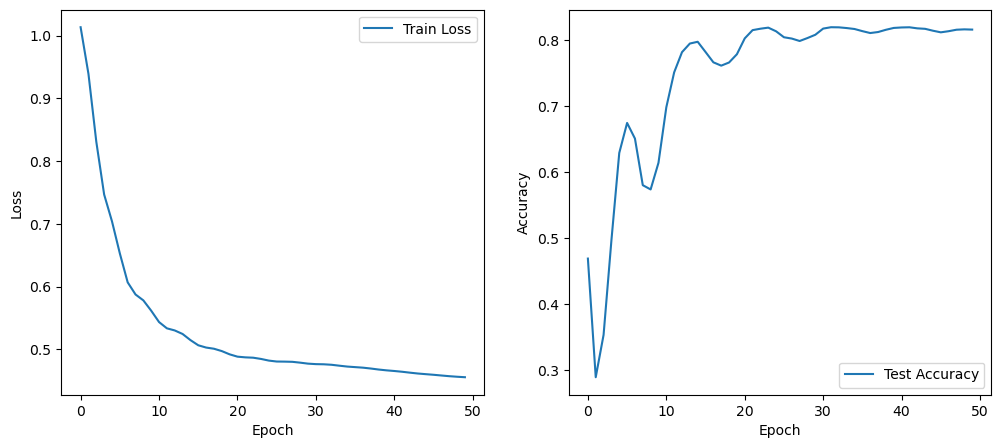

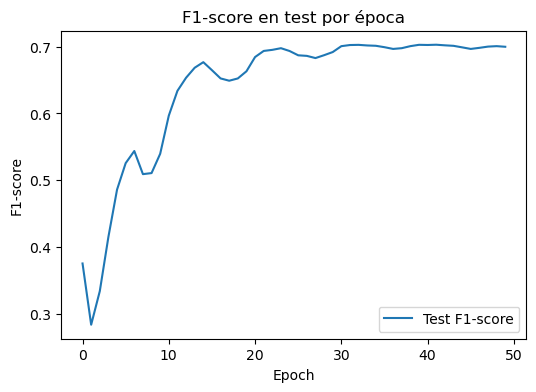

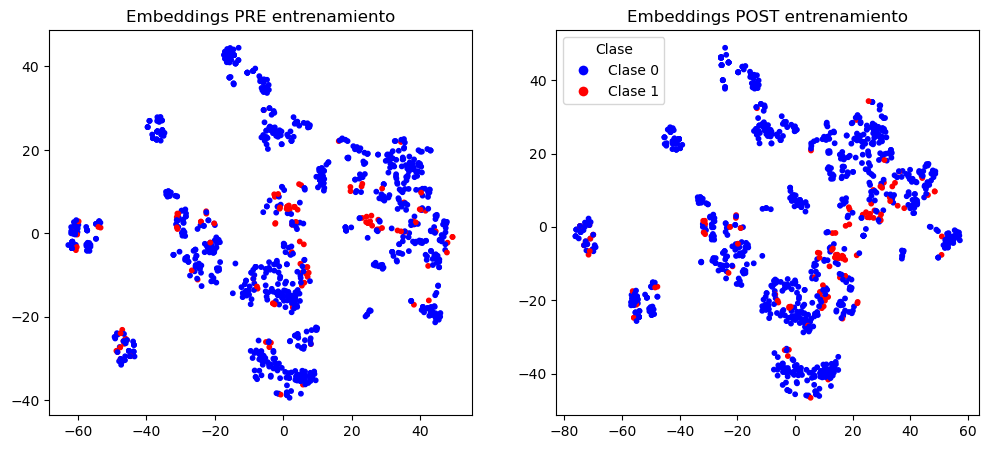

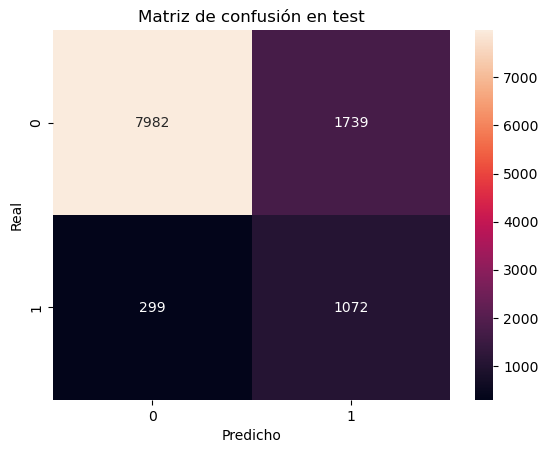

In [210]:
# --- Entrenamiento ---
from sklearn.metrics import f1_score

train_losses = []
test_accs = []
test_f1s = []

for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    try:
        out = model(data.x_dict, data.edge_index_dict)['Product']
        loss = criterion(out[data["Product"].train_mask], data["Product"].y[data["Product"].train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            acc = (pred[data["Product"].test_mask] == data["Product"].y[data["Product"].test_mask]).float().mean()
            f1 = f1_score(
                data["Product"].y[data["Product"].test_mask].cpu().numpy(),
                pred[data["Product"].test_mask].cpu().numpy(),
                average="macro"
            )

        train_losses.append(loss.item())
        test_accs.append(acc.item())
        test_f1s.append(f1)
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f} | F1: {f1:.4f}")
    except Exception as e:
        print(f" Error durante forward pass: {e}")
        break

# --- Embeddings post-entrenamiento ---
model.eval()
with torch.no_grad():
    x = model.conv1(data.x_dict, data.edge_index_dict)
    x = {k: F.relu(v) for k, v in x.items()}
    x = model.conv2(x, data.edge_index_dict)
    prod_emb_post = x["Product"].cpu().numpy()

# --- Curvas de entrenamiento ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(test_f1s, label="Test F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1-score en test por época")
plt.legend()
plt.show()

# --- Visualización de embeddings ---
from sklearn.manifold import TSNE

sample = np.random.choice(prod_emb_pre.shape[0], size=1000, replace=False)
labels_sample = data["Product"].y.cpu().numpy()[sample]

tsne = TSNE(n_components=2, random_state=42)
emb_pre_2d = tsne.fit_transform(prod_emb_pre[sample])
emb_post_2d = tsne.fit_transform(prod_emb_post[sample])

colors = np.array(['blue', 'red']) if num_classes == 2 else plt.cm.tab10(np.arange(num_classes))
label_colors = colors[labels_sample]

plt.figure(figsize=(12,5))
for i, title in enumerate(["PRE entrenamiento", "POST entrenamiento"]):
    plt.subplot(1,2,i+1)
    emb_2d = emb_pre_2d if i == 0 else emb_post_2d
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=label_colors, s=10)
    plt.title(f"Embeddings {title}")
    if i == 1:
        from matplotlib.lines import Line2D
        if num_classes == 2:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Clase 0', markerfacecolor='blue', markersize=8),
                Line2D([0], [0], marker='o', color='w', label='Clase 1', markerfacecolor='red', markersize=8)
            ]
        else:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label=f'Clase {i}', markerfacecolor=plt.cm.tab10(i), markersize=8)
                for i in range(num_classes)
            ]
        plt.legend(handles=legend_elements, title="Clase")
plt.show()

# --- Matriz de confusión ---
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)['Product']
    pred = out.argmax(dim=1).cpu().numpy()
    true = data["Product"].y.cpu().numpy()
    cm = confusion_matrix(true[data["Product"].test_mask.cpu().numpy()],
                          pred[data["Product"].test_mask.cpu().numpy()])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de confusión en test")
    plt.show()

La GNN claramente esta aprendiendo por las curvas y matriz de confusion, pero no se logra visualizar nada de eso en los embeddings antes y despues de entrenar... investigar por que pasa esto.

* Probar otros metodos de reducion de dimensionalidad: como UMAP o Isomap.
* Tal vez los embeddings intrinsecamente de alta dimension. 
* Podria tratarse de oversmoothing ya que no estoy usando regularizacion de ningun tipo ni skip conections, lo que en teoria resulta en embeddings muy similares antes y despues de entrenar.

## Escenario B: Modelo Solo features del producto (sin aristas hasChemical)

Codigo usando el grafo sin las aristas hasChemical (y su inversa) 

Epoch 01 | Loss: 0.8946 | Test Acc: 0.2053 | F1: 0.2053
Epoch 02 | Loss: 0.7221 | Test Acc: 0.6649 | F1: 0.4792
Epoch 03 | Loss: 0.7577 | Test Acc: 0.8255 | F1: 0.5461
Epoch 04 | Loss: 0.6907 | Test Acc: 0.7944 | F1: 0.5509
Epoch 05 | Loss: 0.6244 | Test Acc: 0.6570 | F1: 0.5308
Epoch 06 | Loss: 0.6213 | Test Acc: 0.5406 | F1: 0.4801
Epoch 07 | Loss: 0.6275 | Test Acc: 0.5037 | F1: 0.4584
Epoch 08 | Loss: 0.6062 | Test Acc: 0.5508 | F1: 0.4932
Epoch 09 | Loss: 0.5732 | Test Acc: 0.6339 | F1: 0.5493
Epoch 10 | Loss: 0.5559 | Test Acc: 0.7197 | F1: 0.5961
Epoch 11 | Loss: 0.5597 | Test Acc: 0.8093 | F1: 0.6361
Epoch 12 | Loss: 0.5622 | Test Acc: 0.8270 | F1: 0.6432
Epoch 13 | Loss: 0.5499 | Test Acc: 0.8265 | F1: 0.6586
Epoch 14 | Loss: 0.5327 | Test Acc: 0.7895 | F1: 0.6545
Epoch 15 | Loss: 0.5249 | Test Acc: 0.7407 | F1: 0.6289
Epoch 16 | Loss: 0.5270 | Test Acc: 0.7037 | F1: 0.6025
Epoch 17 | Loss: 0.5284 | Test Acc: 0.6976 | F1: 0.5991
Epoch 18 | Loss: 0.5231 | Test Acc: 0.7072 | F1:

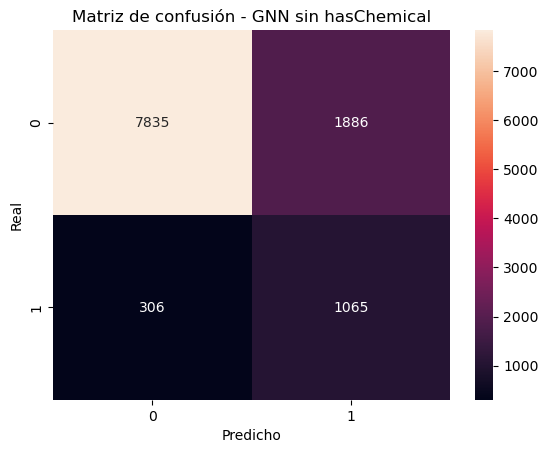

In [ ]:
import copy
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GraphConv, Linear

# 1. Copia el grafo y elimina las aristas hasChemical y su inversa
data_no_chem = copy.deepcopy(data)
if ("Product", "hasChemical", "Chemical") in data_no_chem.edge_index_dict:
    del data_no_chem.edge_index_dict[("Product", "hasChemical", "Chemical")]
if ("Chemical", "hasChemical_rev", "Product") in data_no_chem.edge_index_dict:
    del data_no_chem.edge_index_dict[("Chemical", "hasChemical_rev", "Product")]

# 2. Recalcula valid_edge_types para este grafo
valid_edge_types_no_chem = [
    (src, rel, dst)
    for (src, rel, dst), edge_index in data_no_chem.edge_index_dict.items()
    if edge_index is not None and edge_index.shape[1] > 0
]

# 3. Calcula in_channels automáticamente
in_channels_no_chem = {
    ntype: data_no_chem[ntype].x.shape[1]
    for ntype in data_no_chem.node_types
    if getattr(data_no_chem[ntype], "x", None) is not None
}

num_classes = int(data_no_chem["Product"].y.max().item() + 1)

# 4. Define el modelo adaptado
class ProductGNNNoChem(torch.nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        conv1_dict = {}
        for (src, rel, dst) in valid_edge_types_no_chem:
            conv1_dict[(src, rel, dst)] = GraphConv(
                (in_channels_no_chem[src], in_channels_no_chem[dst]), hidden
            )
        self.conv1 = HeteroConv(conv1_dict, aggr='sum')

        conv2_dict = {
            edge_type: GraphConv((hidden, hidden), hidden)
            for edge_type in conv1_dict
        }
        self.conv2 = HeteroConv(conv2_dict, aggr='sum')
        self.lin = Linear(hidden, num_classes)

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        out_dict = x.copy()
        out_dict["Product"] = self.lin(x["Product"])
        return out_dict

# 5. Pesos de clase
labels = data_no_chem["Product"].y.cpu().numpy()
class_sample_count = np.bincount(labels)
weight = 1. / class_sample_count
weights = torch.tensor(weight, dtype=torch.float, device=data_no_chem["Product"].y.device)

# 6. Instancia y entrena el modelo
model_no_chem = ProductGNNNoChem(hidden=64)
optimizer = torch.optim.Adam(model_no_chem.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

train_mask = data_no_chem["Product"].train_mask
test_mask = data_no_chem["Product"].test_mask

# 7. Entrenamiento
from sklearn.metrics import f1_score

train_losses = []
test_accs = []
test_f1s = []

for epoch in range(1, 51):
    model_no_chem.train()
    optimizer.zero_grad()
    try:
        out = model_no_chem(data_no_chem.x_dict, data_no_chem.edge_index_dict)['Product']
        loss = criterion(out[train_mask], data_no_chem["Product"].y[train_mask])
        loss.backward()
        optimizer.step()

        model_no_chem.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            acc = (pred[test_mask] == data_no_chem["Product"].y[test_mask]).float().mean()
            f1 = f1_score(
                data_no_chem["Product"].y[test_mask].cpu().numpy(),
                pred[test_mask].cpu().numpy(),
                average="macro"
            )

        train_losses.append(loss.item())
        test_accs.append(acc.item())
        test_f1s.append(f1)
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f} | F1: {f1:.4f}")
    except Exception as e:
        print(f" Error durante forward pass: {e}")
        break

# 8. Evaluación final y matriz de confusión
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_no_chem.eval()
with torch.no_grad():
    out = model_no_chem(data_no_chem.x_dict, data_no_chem.edge_index_dict)['Product']
    pred = out[test_mask].argmax(dim=1).cpu().numpy()
    true = data_no_chem["Product"].y[test_mask].cpu().numpy()
    f1 = f1_score(true, pred, average="macro")
    print(f"GNN sin hasChemical - Test F1: {f1:.4f}")

    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de confusión - GNN sin hasChemical")
    plt.show()

## Escenario C (features de químicos en cero)

Código para el escenario C:
GNN con aristas hasChemical, pero los features de los químicos puestos en cero. Así puedes ver si la GNN realmente usa los features de los químicos y no solo la estructura.

Epoch 01 | Loss: 0.9818 | Test Acc: 0.8749 | F1: 0.4833
Epoch 02 | Loss: 0.6050 | Test Acc: 0.7629 | F1: 0.6017
Epoch 03 | Loss: 0.7088 | Test Acc: 0.5173 | F1: 0.4676
Epoch 04 | Loss: 0.7428 | Test Acc: 0.4732 | F1: 0.4366
Epoch 05 | Loss: 0.6642 | Test Acc: 0.5499 | F1: 0.4921
Epoch 06 | Loss: 0.5649 | Test Acc: 0.6845 | F1: 0.5863
Epoch 07 | Loss: 0.5349 | Test Acc: 0.8354 | F1: 0.6941
Epoch 08 | Loss: 0.5779 | Test Acc: 0.8569 | F1: 0.6480
Epoch 09 | Loss: 0.5976 | Test Acc: 0.8594 | F1: 0.6504
Epoch 10 | Loss: 0.5656 | Test Acc: 0.8554 | F1: 0.6524
Epoch 11 | Loss: 0.5187 | Test Acc: 0.8422 | F1: 0.6935
Epoch 12 | Loss: 0.5004 | Test Acc: 0.7532 | F1: 0.6425
Epoch 13 | Loss: 0.5137 | Test Acc: 0.7338 | F1: 0.6285
Epoch 14 | Loss: 0.5306 | Test Acc: 0.7055 | F1: 0.6071
Epoch 15 | Loss: 0.5321 | Test Acc: 0.7006 | F1: 0.6033
Epoch 16 | Loss: 0.5171 | Test Acc: 0.7228 | F1: 0.6205
Epoch 17 | Loss: 0.4964 | Test Acc: 0.7384 | F1: 0.6322
Epoch 18 | Loss: 0.4847 | Test Acc: 0.7665 | F1:

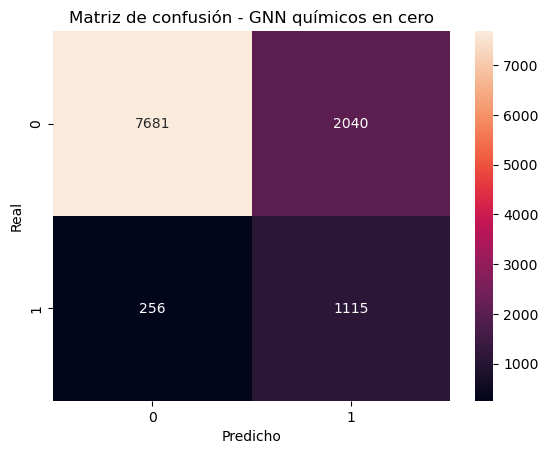

In [212]:
import copy
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GraphConv, Linear

# 1. Copia el grafo y pone en cero los features de los químicos
data_chem_zero = copy.deepcopy(data)
data_chem_zero["Chemical"].x = torch.zeros_like(data_chem_zero["Chemical"].x)

# 2. Recalcula valid_edge_types para este grafo
valid_edge_types_chem_zero = [
    (src, rel, dst)
    for (src, rel, dst), edge_index in data_chem_zero.edge_index_dict.items()
    if edge_index is not None and edge_index.shape[1] > 0
]

# 3. Calcula in_channels automáticamente
in_channels_chem_zero = {
    ntype: data_chem_zero[ntype].x.shape[1]
    for ntype in data_chem_zero.node_types
    if getattr(data_chem_zero[ntype], "x", None) is not None
}

num_classes = int(data_chem_zero["Product"].y.max().item() + 1)

# 4. Define el modelo adaptado
class ProductGNNChemZero(torch.nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        conv1_dict = {}
        for (src, rel, dst) in valid_edge_types_chem_zero:
            conv1_dict[(src, rel, dst)] = GraphConv(
                (in_channels_chem_zero[src], in_channels_chem_zero[dst]), hidden
            )
        self.conv1 = HeteroConv(conv1_dict, aggr='sum')

        conv2_dict = {
            edge_type: GraphConv((hidden, hidden), hidden)
            for edge_type in conv1_dict
        }
        self.conv2 = HeteroConv(conv2_dict, aggr='sum')
        self.lin = Linear(hidden, num_classes)

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        out_dict = x.copy()
        out_dict["Product"] = self.lin(x["Product"])
        return out_dict

# 5. Pesos de clase
labels = data_chem_zero["Product"].y.cpu().numpy()
class_sample_count = np.bincount(labels)
weight = 1. / class_sample_count
weights = torch.tensor(weight, dtype=torch.float, device=data_chem_zero["Product"].y.device)

# 6. Instancia y entrena el modelo
model_chem_zero = ProductGNNChemZero(hidden=64)
optimizer = torch.optim.Adam(model_chem_zero.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

train_mask = data_chem_zero["Product"].train_mask
test_mask = data_chem_zero["Product"].test_mask

# 7. Entrenamiento
from sklearn.metrics import f1_score

train_losses = []
test_accs = []
test_f1s = []

for epoch in range(1, 51):
    model_chem_zero.train()
    optimizer.zero_grad()
    try:
        out = model_chem_zero(data_chem_zero.x_dict, data_chem_zero.edge_index_dict)['Product']
        loss = criterion(out[train_mask], data_chem_zero["Product"].y[train_mask])
        loss.backward()
        optimizer.step()

        model_chem_zero.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            acc = (pred[test_mask] == data_chem_zero["Product"].y[test_mask]).float().mean()
            f1 = f1_score(
                data_chem_zero["Product"].y[test_mask].cpu().numpy(),
                pred[test_mask].cpu().numpy(),
                average="macro"
            )

        train_losses.append(loss.item())
        test_accs.append(acc.item())
        test_f1s.append(f1)
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f} | F1: {f1:.4f}")
    except Exception as e:
        print(f" Error durante forward pass: {e}")
        break

# 8. Evaluación final y matriz de confusión
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_chem_zero.eval()
with torch.no_grad():
    out = model_chem_zero(data_chem_zero.x_dict, data_chem_zero.edge_index_dict)['Product']
    pred = out[test_mask].argmax(dim=1).cpu().numpy()
    true = data_chem_zero["Product"].y[test_mask].cpu().numpy()
    f1 = f1_score(true, pred, average="macro")
    print(f"GNN con features de químicos en cero - Test F1: {f1:.4f}")

    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de confusión - GNN químicos en cero")
    plt.show()

## Resumen resultados modelos a priori: 

Escenario A (con aristas hasChemical y features de químicos):
Mejor en clase 1 que A, lo que indica que la información relacional ayuda a identificar mejor la clase minoritaria o más difícil.

Escenario B (sin aristas hasChemical):
Mejor en clase 0 (Esperable al ser la clase mayoritaria y la más fácil de predecir solo con features del producto).

Escenario C (con aristas hasChemical pero features de químicos en cero):
Es el mejor en clase 1, pero el peor en clase 0. Esto sugiere que la estructura del grafo (saber qué productos comparten químicos, aunque no sepa qué químicos son) ayuda a la GNN a identificar patrones útiles para la clase 1, pero puede confundirla para la clase 0 si no tiene los features reales de los químicos.

## Comparacion con metodos de machine learning clasicos.

In [ ]:
import pandas as pd
import numpy as np

# Carga del CSV
df = pd.read_csv("cosmetics2.csv")

# --- Preprocesamiento de datos ---
# Etiqueta: ¿está descontinuado?
df['Discontinued'] = df['DiscontinuedDate'].notnull().astype(int)

# Me interesa mas la relación entre productos y químicos, asi que solo indico si un producto tiene o no un CSF y brand
# ¿Tiene CSF?
df['HasCSF'] = df['CSFId'].notnull().astype(int)

# ¿Tiene BrandName?
df['HasBrand'] = df['BrandName'].notnull().astype(int)

# --- One-hot encoding de químicos por producto ---
# QNos quedamos con las columnas relevantes para la relación producto-químico
df_prod_chem = df[['ProductName', 'ChemicalName']].drop_duplicates()

# Tabla de presencia de químicos
product_chem = pd.crosstab(df_prod_chem['ProductName'], df_prod_chem['ChemicalName'])

# Features agregados (sin fechas ni edad)
agg = df.groupby('ProductName').agg({
    'Discontinued': 'max',
    'HasCSF': 'max',
    'HasBrand': 'max',
    'CompanyId': 'first', # TOMO el primero, pero podría ser un problema si hay, pero mi interes esta en los quimicos
    'PrimaryCategoryId': 'first', # igual que CompanyId
    'SubCategoryId': 'first' # igual que CompanyId
}).reset_index()

# Se unen los features agregados con la matriz de químicos
agg = agg.merge(product_chem, left_on='ProductName', right_index=True)

# Opcional: codificar CompanyId, PrimaryCategoryId, SubCategoryId como categóricos
# agg = pd.get_dummies(agg, columns=['CompanyId', 'PrimaryCategoryId', 'SubCategoryId'])


In [11]:
# Entrena el modelo clásico
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = agg.drop(['ProductName', 'Discontinued'], axis=1)
y = agg['Discontinued']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=50,
    max_depth=10,
    n_jobs=-1  # Usa todos los núcleos disponibles
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.61      0.74      8820
           1       0.23      0.82      0.36      1295

    accuracy                           0.63     10115
   macro avg       0.60      0.71      0.55     10115
weighted avg       0.86      0.63      0.69     10115



CompanyId: 0.4285
SubCategoryId: 0.1326
PrimaryCategoryId: 0.1132
Cocamide diethanolamine: 0.0640
Mineral oils, untreated and mildly treated: 0.0363
Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.: 0.0341
Mica: 0.0245
HasCSF: 0.0203
Talc: 0.0202
Titanium dioxide: 0.0179
Trade Secret: 0.0162
Silica, crystalline (airborne particles of respirable size): 0.0155
Triethanolamine: 0.0098
Retinyl palmitate: 0.0077
Cosmetic talc: 0.0061
Carbon black: 0.0045
HasBrand: 0.0039
Vitamin A palmitate: 0.0037
Methyleugenol: 0.0034
Coffea arabica extract: 0.0027
Retinol: 0.0026
Aloe vera, whole leaf extract: 0.0022
Carbon black (airborne, unbound particles of respirable size): 0.0021
Butylated hydroxyanisole: 0.0020
Quartz: 0.0019
Formaldehyde (gas): 0.0017
Diethanolamine: 0.0015
Cocamide MEA: 0.0015
Estragole: 0.0014
Safrole: 0.0013
Acetaldehyde: 0.0009
Isopropyl alcohol manufacture using strong acids: 0.0009
Caffeine: 0.0008
Goldenseal root powder: 0

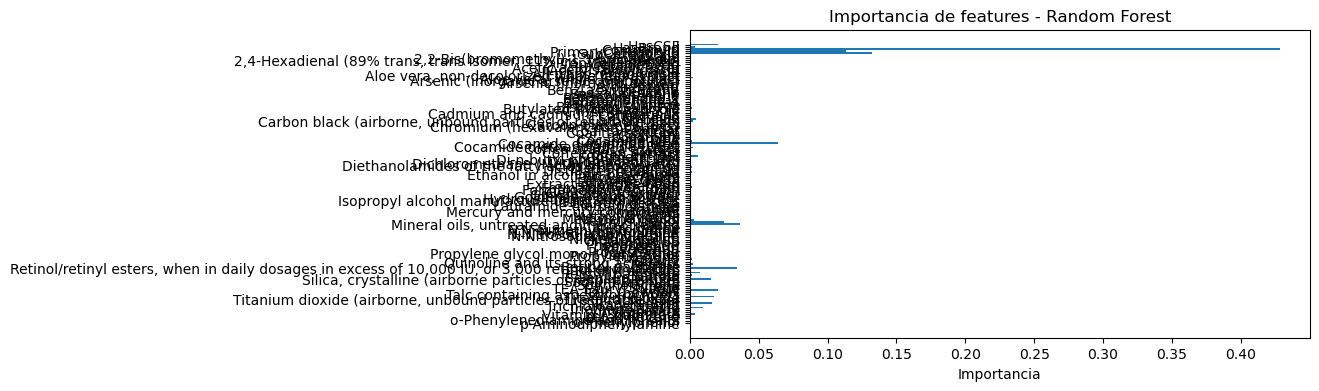

In [12]:
import matplotlib.pyplot as plt

# Asumiendo que ya entrenaste clf y tienes X_train
importances = clf.feature_importances_
feature_names = X.columns

# Mostrar importancias ordenadas
for name, imp in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.4f}")

# Gráfica de barras
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.title("Importancia de features - Random Forest")
plt.gca().invert_yaxis()
plt.show()

ksadnsadakl son muchas variables. Me ineresa ver la relevancia que tienen ciertos quimicos en la clasficación, vemos la importancia solo de estos:

Top 20 químicos más importantes:
ChemicalName 'Cocamide diethanolamine': 0.0640
ChemicalName 'Mineral oils, untreated and mildly treated': 0.0363
ChemicalName 'Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.': 0.0341
ChemicalName 'Mica': 0.0245
ChemicalName 'Talc': 0.0202
ChemicalName 'Titanium dioxide': 0.0179
ChemicalName 'Trade Secret': 0.0162
ChemicalName 'Silica, crystalline (airborne particles of respirable size)': 0.0155
ChemicalName 'Triethanolamine': 0.0098
ChemicalName 'Retinyl palmitate': 0.0077
ChemicalName 'Cosmetic talc': 0.0061
ChemicalName 'Carbon black': 0.0045
ChemicalName 'Vitamin A palmitate': 0.0037
ChemicalName 'Methyleugenol': 0.0034
ChemicalName 'Coffea arabica extract': 0.0027
ChemicalName 'Retinol': 0.0026
ChemicalName 'Aloe vera, whole leaf extract': 0.0022
ChemicalName 'Carbon black (airborne, unbound particles of respirable size)': 0.0021
ChemicalName 'Butylated hydroxyanisole': 0.0020
ChemicalName 'Quartz

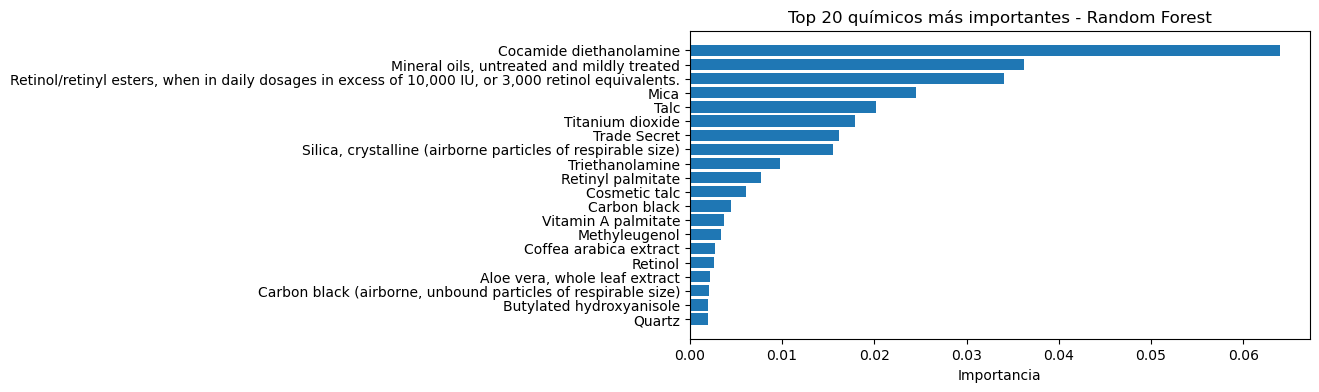

In [ ]:
# Encuentrar las columnas que corresponden a los químicos (ChemicalName)
chemical_cols = [col for col in X.columns if col in df['ChemicalName'].unique()]

# Se obtienen las importancias de los químicos
chem_importances = [(col, imp) for col, imp in zip(X.columns, clf.feature_importances_) if col in chemical_cols]

# Ordenando de mayor a menor importancia
chem_importances = sorted(chem_importances, key=lambda x: -x[1])

# Muestra los 20 químicos más importantes
print("Top 20 químicos más importantes:")
for name, imp in chem_importances[:20]:
    print(f"ChemicalName '{name}': {imp:.4f}")

# Grafico de los 20 más importantes
import matplotlib.pyplot as plt

top_names = [str(name) for name, _ in chem_importances[:20]]
top_imps = [imp for _, imp in chem_importances[:20]]

plt.figure(figsize=(8,4))
plt.barh(top_names, top_imps)
plt.xlabel("Importancia")
plt.title("Top 20 químicos más importantes - Random Forest")
plt.gca().invert_yaxis()
plt.show()